In [1]:
import os, glob, re
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import stats
import torch
import matplotlib.pyplot as plt
import math
from typing import Dict, Tuple, Optional
# show super-wide tables without wrapping/truncating
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 0)           # auto-detect terminal width
pd.set_option("display.max_colwidth", None) # don't truncate long strings




# Produce Main T-Test Tables (Table 3, 6-10)

In [6]:
def analyze_models(model_names, method_list, benchmark_names, root_dir,
                   csv_name="cross_benchmark_summary_main.csv",
                   csv_alt_names="cross_benchmark_summary.csv",
                   feature="residual", n_seeds=15, hyper_parameter=False):

    all_results = []

    # normalize alt names
    if csv_alt_names is None:
        alt_names = []
    elif isinstance(csv_alt_names, str):
        alt_names = [csv_alt_names]
    else:
        alt_names = list(csv_alt_names)

    for model_name in model_names:
        # containers for numeric deltas (when hyper_parameter=False)
        benchmark_deltas = {b: {m: [] for m in method_list} for b in benchmark_names}

        # containers for hyper-parameters (always collect; only printed if hyper_parameter=True)
        layers_hist = {b: {m: [] for m in method_list} for b in benchmark_names}
        strengths_hist = {b: {m: [] for m in method_list} for b in benchmark_names}

        for seed in range(1, n_seeds + 1):
            tables_dir = os.path.join(root_dir, model_name, feature, f"seed_{seed}", "tables")
            candidates = [csv_name] + alt_names

            csv_path = None
            for cand in candidates:
                path_try = os.path.join(tables_dir, cand)
                if os.path.exists(path_try):
                    csv_path = path_try
                    break
            if csv_path is None:
                print(f"Missing all candidates in {tables_dir}: {', '.join(candidates)}")
                continue

            df = pd.read_csv(csv_path)

            for bmark_name in benchmark_names:
                df_b = df[df['Benchmark'] == bmark_name]
                if df_b.empty:
                    continue

                # Unsteered accuracy (only needed when hyper_parameter is False)
                if not hyper_parameter:
                    try:
                        acc_unsteered = df_b[df_b['Method'] == "Unsteered"]['Test-Acc'].values[0]
                    except IndexError:
                        continue

                for method in method_list:
                    if df_b[df_b['Method'] == method].empty:
                        continue
                    row = df_b[df_b['Method'] == method].iloc[0]

                    # Collect hyper-parameters if present
                    # Accept both {Layer,Strength} and {Steering_Layer,Steering_Strength}
                    layer_val = None
                    if 'Layer' in row and pd.notna(row['Layer']):
                        layer_val = row['Layer']
                    elif 'Steering_Layer' in row and pd.notna(row['Steering_Layer']):
                        layer_val = row['Steering_Layer']

                    strength_val = None
                    if 'Strength' in row and pd.notna(row['Strength']):
                        strength_val = row['Strength']
                    elif 'Steering_Strength' in row and pd.notna(row['Steering_Strength']):
                        strength_val = row['Steering_Strength']

                    if layer_val is not None:
                        try:
                            layers_hist[bmark_name][method].append(int(float(layer_val)))
                        except Exception:
                            pass  # ignore cast errors, e.g., empty strings

                    if strength_val is not None:
                        try:
                            strengths_hist[bmark_name][method].append(float(strength_val))
                        except Exception:
                            pass

                    # When not printing hyper-parameters, still compute deltas 
                    if not hyper_parameter:
                        try:
                            acc_steered = row['Test-Acc']
                            delta = float(acc_steered) - float(acc_unsteered)
                            benchmark_deltas[bmark_name][method].append(delta)
                        except Exception:
                            continue

        # Build output rows
        for bmark in benchmark_names:
            row_out = {'Model': model_name, 'Benchmark': bmark}

            for method in method_list:
                if hyper_parameter:
                    # Only print hyper-parameter lists; no stats
                    Ls = layers_hist[bmark][method]
                    Ss = strengths_hist[bmark][method]

                    if not Ls and not Ss:
                        row_out[method] = "-"
                    else:
                        # Pretty-print lists (integers for layers; 2 decimals for strengths)
                        ss_print = [f"{s:.2f}" for s in Ss]
                        row_out[method] = f"L={Ls}; S={ss_print}"
                else:
                    # Original behavior: compute mean/CI/p-value
                    deltas = benchmark_deltas[bmark][method]
                    if len(deltas) >= 3:
                        mean = np.mean(deltas)
                        std_err = stats.sem(deltas)
                        ci = stats.t.interval(0.95, len(deltas)-1, loc=mean, scale=std_err)

                        if feature == "catastrophic_forgetting":
                            _, pval = stats.ttest_1samp(deltas, 0.0, alternative='less')
                        else:
                            _, pval = stats.ttest_1samp(deltas, 0.0, alternative='greater')

                        row_out[method] = f"{mean:.2f} [{ci[0]:.2f},{ci[1]:.2f}], p={pval:.2f}"
                    else:
                        row_out[method] = "-"

            all_results.append(row_out)

    return pd.DataFrame(all_results)


In [ ]:
model_list = [
    "NousResearch-Nous-Hermes-2-Mistral-7B-DPO",
    "deepseek-ai-DeepSeek-R1-Distill-Llama-8B",
    "meta-llama-Llama-3.1-8B-Instruct"
]

# model_list = [
#     "joyfine-vicuna-7b-fine-tuning_truthfulQA_128_20",
#     "lmsys-vicuna-7b-v1.5"
# ]

methods = ["iBAS_all", "iBAS_wrong_only", "BAS_full_mcq"]


benchmarks = [
    "DisabilityStatus",
    "GenderIdentity",
    "Nationality",
    "PhysicalAppearance",
    "RaceEthnicity",
    "RaceXGender",
    "RaceXSES",
    "Religion",
    "SES",
    "SexualOrientation",
    "ETHICS_Commonsense",
    "ETHICS_Deontology",
    "ETHICS_Justice",
    "Sycophancy",
    "TruthfulQA"
]

# benchmarks = [
#     "OpenBookQA",
#     "ARCChallenge",
#     "LSAT"
    
# ]

root_dir = "output_scale_up"
csv_name = "cross_benchmark_summary_main.csv"

# Table 3 and 6
# df = analyze_models(model_list, methods, benchmarks, root_dir, feature = "residual", csv_name = csv_name, n_seeds=15)

# Table 5
# df = analyze_models(model_list, methods, benchmarks, root_dir, feature = "catastrophic_forgetting", csv_name = csv_name, n_seeds=15)

# Table 7-9
df = analyze_models(model_list, methods, benchmarks, root_dir, feature = "self_attn", csv_name = csv_name, n_seeds=15)
# df = analyze_models(model_list, methods, benchmarks, root_dir, feature = "post_attn", csv_name = csv_name, n_seeds=15)
# df = analyze_models(model_list, methods, benchmarks, root_dir, feature = "mlp", csv_name = csv_name, n_seeds=15)
# df = analyze_models(model_list, methods, benchmarks, root_dir, feature = "ICL", csv_name = csv_name, n_seeds=15)



# Produce Raw Accuracy Tables for Unsteered Models (Table 2)

In [9]:
def summarize_unsteered_accuracy_table(
    model_names,
    benchmark_names,
    root_dir,
    csv_name="cross_benchmark_summary_main.csv",            # main
    csv_alt_names=("cross_benchmark_summary.csv",),         # fallbacks
    feature="residual",
    feature_candidates=("self_attn","post_attn","mlp","ICL","residual"),
    fmt="mean_ci",        # "mean_ci" | "mean" | "raw"
    verbose=False
):
    """
    Build a Benchmark × Model table of Unsteered 'Test-Acc'.

    Robust search strategy:
    - For each model and each feature in [feature] + feature_candidates:
      - Search all seed folders via glob: {root}/{model}/{feature}/seed_*/tables/{csv}
      - Try csv_name first, then csv_alt_names (order matters).
    - Normalize method label (accept 'Unsteered' variants).
    """

    # normalize alt names
    if csv_alt_names is None:
        alt_names = []
    elif isinstance(csv_alt_names, str):
        alt_names = [csv_alt_names]
    else:
        alt_names = list(csv_alt_names)

    # feature search order (dedupe but keep order)
    feat_order = [feature] + [f for f in feature_candidates if f != feature]
    seen = set()
    feat_order = [f for f in feat_order if not (f in seen or seen.add(f))]

    def _norm(s):
        return re.sub(r"\s+", " ", str(s)).strip()

    # collect per (model, benchmark)
    acc_store = {m: {b: [] for b in benchmark_names} for m in model_names}

    for model_name in model_names:
        for feat in feat_order:
            # build ordered CSV candidate list (main first)
            csv_candidates = [csv_name] + alt_names

            # search all seed_* folders for each csv candidate
            base = os.path.join(root_dir, model_name, feat)
            if not os.path.isdir(base):
                continue

            # Gather all existing tables files in priority order:
            files_ordered = []
            for csv_file in csv_candidates:
                # seed_* pattern
                files = glob.glob(os.path.join(base, "seed_*", "tables", csv_file))
                # also allow a non-seeded tables dir just in case
                files += glob.glob(os.path.join(base, "tables", csv_file))
                # keep stable order by sorting
                files = sorted(files)
                if files:
                    files_ordered.append((csv_file, files))

            if not files_ordered:
                if verbose:
                    print(f"[miss] {model_name} @ {feat}: no CSVs {csv_candidates}")
                continue

            # walk files in priority order (main first; then alts)
            for csv_file, file_list in files_ordered:
                for csv_path in file_list:
                    try:
                        df = pd.read_csv(csv_path)
                    except Exception:
                        continue

                    # columns
                    bcol = "Benchmark" if "Benchmark" in df.columns else ("Dataset" if "Dataset" in df.columns else ("Task" if "Task" in df.columns else None))
                    if bcol is None or "Method" not in df.columns:
                        if verbose:
                            print(f"[warn] {csv_path}: missing Benchmark/Dataset/Task or Method")
                        continue
                    acc_col = None
                    for cand in ("Test-Acc","TestAcc","Accuracy","Acc"):
                        if cand in df.columns:
                            acc_col = cand
                            break
                    if acc_col is None:
                        if verbose:
                            print(f"[warn] {csv_path}: no accuracy column")
                        continue

                    # normalize method once
                    df["_Method_"] = df["Method"].astype(str).map(_norm)

                    for bmark in benchmark_names:
                        # exact match for your case
                        match = df[(df[bcol].astype(str) == bmark) & (df["_Method_"].str.lower().str.startswith("unsteered"))]
                        if match.empty:
                            continue
                        try:
                            acc_val = float(match.iloc[0][acc_col])
                        except Exception:
                            continue

                        acc_store[model_name][bmark].append(acc_val)
                        if verbose:
                            print(f"[use] {model_name} | {feat} | {os.path.basename(csv_path)} | {bmark} -> {acc_val:.4f}")

    # formatter
    def fmt_cell(values):
        if not values:
            return "-"
        arr = np.asarray(values, dtype=float)
        mean = float(np.mean(arr))
        if fmt == "raw":
            return ", ".join(f"{v:.2f}" for v in arr)
        if fmt == "mean":
            return f"{mean:.2f}"
        # mean_ci
        if len(arr) >= 3:
            se = stats.sem(arr)
            lo, hi = stats.t.interval(0.95, len(arr)-1, loc=mean, scale=se)
            return f"{mean:.2f} [{lo:.2f},{hi:.2f}]"
        else:
            return f"{mean:.2f}"

    # build output table
    table = pd.DataFrame(index=benchmark_names, columns=model_names)
    for b in benchmark_names:
        for m in model_names:
            table.loc[b, m] = fmt_cell(acc_store[m][b])
    table.index.name = "Benchmark"
    return table


In [10]:
model_list = [
    "NousResearch-Nous-Hermes-2-Mistral-7B-DPO",
    "deepseek-ai-DeepSeek-R1-Distill-Llama-8B",
    "meta-llama-Llama-3.1-8B-Instruct"
]

benchmarks = [
    "DisabilityStatus",
    "GenderIdentity",
    "Nationality",
    "PhysicalAppearance",
    "RaceEthnicity",
    "RaceXGender",
    "RaceXSES",
    "Religion",
    "SES",
    "SexualOrientation",
    "ETHICS_Commonsense",
    "ETHICS_Deontology",
    "ETHICS_Justice",
    "Sycophancy",
    "TruthfulQA",
    "OpenBookQA",
    "ARCChallenge",
    "LSAT"
]

root_dir = "output_scale_up"
csv_main = "cross_benchmark_summary_main.csv"
csv_alt  = "cross_benchmark_summary.csv"

df_unsteered = summarize_unsteered_accuracy_table(
    model_names=model_list,
    benchmark_names=benchmarks,
    root_dir=root_dir,
    csv_name=csv_main,                      # try main first
    csv_alt_names=(csv_alt,),               # then alt
    feature="self_attn",                    # default path for most tasks
    feature_candidates=("residual","mlp","post_attn","ICL"),  # will catch OBQA/ARC/LSAT
    fmt="mean_ci",
    verbose=False                           # set True to see exactly what files matched
)

print(df_unsteered)


                   NousResearch-Nous-Hermes-2-Mistral-7B-DPO  \
Benchmark                                                      
DisabilityStatus                            0.65 [0.63,0.66]   
GenderIdentity                              0.70 [0.68,0.72]   
Nationality                                 0.72 [0.70,0.73]   
PhysicalAppearance                          0.71 [0.71,0.72]   
RaceEthnicity                               0.70 [0.68,0.72]   
RaceXGender                                 0.68 [0.66,0.70]   
RaceXSES                                    0.78 [0.77,0.79]   
Religion                                    0.69 [0.68,0.70]   
SES                                         0.73 [0.71,0.75]   
SexualOrientation                           0.76 [0.75,0.77]   
ETHICS_Commonsense                          0.70 [0.70,0.71]   
ETHICS_Deontology                           0.56 [0.54,0.58]   
ETHICS_Justice                              0.67 [0.66,0.68]   
Sycophancy                              

# Figure 1

In [ ]:
def plot_avg_steering_effects_stacked(model_names, method_list, benchmark_names, root_dir,
                                      csv_name="cross_benchmark_summary_main.csv",
                                      csv_alt_names="cross_benchmark_summary.csv",
                                      feature="residual", n_seeds=15,
                                      method_labels=None, figsize=(12,12),
                                      savepath="plots/avg_steering_effects_model-behavior_stacked.pdf"):
    if csv_alt_names is None:
        alt_names = []
    elif isinstance(csv_alt_names, str):
        alt_names = [csv_alt_names]
    else:
        alt_names = list(csv_alt_names)

    if method_labels is None:
        method_labels = {
            "iBAS_all": "iPASa",
            "iBAS_wrong_only": "iPASwo",
            "BAS_full_mcq": "PASf",
        }

    def _find_csv_for_seed(model, seed):
        tables_dir = os.path.join(
            root_dir, model, *( [feature] if feature else [] ), f"seed_{seed}", "tables"
        )
        for cand in [csv_name] + alt_names:
            p = os.path.join(tables_dir, cand)
            if os.path.exists(p):
                return p
        return None

    rows = []
    for model_name in model_names:
        pattern = os.path.join(
            root_dir, model_name, *( [feature] if feature else [] ),
            "seed_*", "tables", "*benchmark_summary*.csv"
        )
        seed_paths = glob.glob(pattern)
        detected = sorted({ int(p.split(os.sep)[-3].split("_")[-1]) for p in seed_paths })
        use_seeds = detected if n_seeds is None else detected[:n_seeds]

        deltas = {b: {m: [] for m in method_list} for b in benchmark_names}

        for s in use_seeds:
            csv_path = _find_csv_for_seed(model_name, s)
            if not csv_path:
                continue
            df = pd.read_csv(csv_path)

            for b in benchmark_names:
                sub = df[df["Benchmark"] == b]
                if sub.empty:
                    continue
                u = sub.loc[sub["Method"] == "Unsteered", "Test-Acc"].values
                if len(u) == 0:
                    continue
                u = float(u[0])
                for m in method_list:
                    v = sub.loc[sub["Method"] == m, "Test-Acc"].values
                    if len(v) == 0:
                        continue
                    deltas[b][m].append(float(v[0]) - u)

        for b in benchmark_names:
            for m in method_list:
                arr = np.asarray(deltas[b][m], dtype=float)
                if len(arr) == 0:
                    continue
                rows.append({
                    "Model": model_name,
                    "Benchmark": b,
                    "Method": m,
                    "mean_delta": float(np.mean(arr)),
                    "n_seeds": len(arr),
                })

    df_model = pd.DataFrame(rows)
    if df_model.empty:
        print("No data found to plot.")
        return

    agg = (
        df_model
        .groupby(["Benchmark", "Method"], as_index=False)
        .agg(
            avg_mean=("mean_delta", "mean"),
            model_se=("mean_delta", lambda x: np.std(x, ddof=1)/np.sqrt(len(x)) if len(x) > 1 else np.nan),
            k_models=("Model", "nunique")
        )
    )

    bench_order = benchmark_names  # keep all, including ETHICS

    plot_df = agg.set_index(["Benchmark","Method"]).loc[pd.IndexSlice[bench_order, method_list], :].reset_index()
    heights = plot_df.pivot(index="Benchmark", columns="Method", values="avg_mean").reindex(bench_order)
    errs    = plot_df.pivot(index="Benchmark", columns="Method", values="model_se").reindex(bench_order)

    heights.columns = [method_labels.get(c, c) for c in heights.columns]
    errs.columns    = [method_labels.get(c, c) for c in errs.columns]

    # relabel SES and strip ETHICS_ prefix
    def clean_label(b):
        if b == "SES":
            return r"Socio-Economic Status"
        if b == "RaceXGender":
            return r"Race & Gender"
        if b == "RaceXSES":
            return r"Race & SES"
        if b.startswith("ETHICS_"):
            return b.replace("ETHICS_", "")
        return b

    xtick_labels = [clean_label(b) for b in heights.index]

    # --- First 8, then remaining 7 ---
    chunks = [bench_order[:8], bench_order[8:]]

    fig, axes = plt.subplots(len(chunks), 1, figsize=figsize, sharey=False)

    for ax, chunk in zip(axes, chunks):
        sub_heights = heights.loc[chunk]
        sub_errs    = errs.loc[chunk]
        sub_labels  = [clean_label(b) for b in chunk]

        x = np.arange(len(sub_heights.index))
        nM = len(sub_heights.columns)
        bar_w = 0.8 / max(nM, 1)

        for i, m in enumerate(sub_heights.columns):
            y = sub_heights[m].to_numpy()
            e = sub_errs[m].to_numpy()
            offset = i*bar_w - 0.4 + bar_w*(nM/2)
            ax.bar(x + offset, y, width=bar_w, label=m, yerr=e, capsize=3)

        ax.axhline(0.0, color="k", linewidth=1)
        ax.set_xticks(x)
        ax.set_xticklabels(sub_labels, rotation=45, ha="right", fontsize=18)  # BIG x tick labels
        ax.set_ylabel("Δ accuracy", fontsize=20)  # BIG y axis label
        ax.tick_params(axis='y', labelsize=18)    # BIG y tick labels

    fig.suptitle("Average Steering Effect Across Models on Model-Behavior Tasks", fontsize=22)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, labels, title="Method",
        loc="upper center", bbox_to_anchor=(0.5, 0.06),  # below plots
        ncol=len(labels), fontsize=18, title_fontsize=20
    )


    plt.tight_layout(rect=[0,0,0.9,0.95])

    os.makedirs(os.path.dirname(savepath), exist_ok=True)
    plt.savefig(savepath, format="pdf", bbox_inches="tight")
    plt.close()
    print(f"Plot saved to {savepath}")



# Example call
plot_avg_steering_effects_stacked(
    model_names=[
        "NousResearch-Nous-Hermes-2-Mistral-7B-DPO",
        "deepseek-ai-DeepSeek-R1-Distill-Llama-8B",
        "meta-llama-Llama-3.1-8B-Instruct",
    ],
    method_list=["iBAS_all", "iBAS_wrong_only", "BAS_full_mcq"],
    benchmark_names=[
        "DisabilityStatus","GenderIdentity","Nationality","PhysicalAppearance",
        "RaceEthnicity","RaceXGender","RaceXSES","Religion","SES","SexualOrientation",
        "ETHICS_Commonsense","ETHICS_Deontology","ETHICS_Justice","Sycophancy","TruthfulQA"
    ],
    root_dir="output_scale_up",
    csv_name="cross_benchmark_summary_main.csv",
    csv_alt_names="cross_benchmark_summary.csv",
    feature="residual",
    n_seeds=15,
    savepath=None
)


# Results for the 3 Classifications of Tasks

In [ ]:
# ---- (1) classify benchmarks into 3 categories) ----
def classify_benchmark(bmark_name: str) -> str:
    social_bias = {
        "DisabilityStatus","GenderIdentity","Nationality","PhysicalAppearance",
        "RaceEthnicity","RaceXGender","RaceXSES","Religion","SES","SexualOrientation",
    }
    morality = {"Commonsense","Deontology","Justice"}
    if bmark_name in social_bias:
        return "Social Bias"
    if bmark_name.startswith("ETHICS_") or bmark_name in morality:
        return "Morality"
    return "Alignment"

# ---- aggregate by the 3 categories across models & benchmarks) ----
def analyze_by_category(model_names, method_list, benchmark_names, root_dir,
                        csv_name="cross_benchmark_summary_main.csv",
                        csv_alt_names="cross_benchmark_summary.csv",
                        feature="residual", n_seeds=15):

    # normalize alt names
    if csv_alt_names is None:
        alt_names = []
    elif isinstance(csv_alt_names, str):
        alt_names = [csv_alt_names]
    else:
        alt_names = list(csv_alt_names)

    categories = ["Social Bias", "Morality", "Alignment"]
    deltas_by_cat = {cat: {m: [] for m in method_list} for cat in categories}

    def _find_csv_for_seed(model, seed):
        tables_dir = os.path.join(root_dir, model, *( [feature] if feature else [] ), f"seed_{seed}", "tables")
        for cand in [csv_name] + alt_names:
            p = os.path.join(tables_dir, cand)
            if os.path.exists(p):
                return p
        return None

    for model_name in model_names:
        pattern = os.path.join(root_dir, model_name, *( [feature] if feature else [] ),
                               "seed_*", "tables", "*benchmark_summary*.csv")
        seed_paths = glob.glob(pattern)
        detected = sorted({int(p.split(os.sep)[-3].split("_")[-1]) for p in seed_paths})
        use_seeds = detected if n_seeds is None else detected[:n_seeds]

        for seed in use_seeds:
            csv_path = _find_csv_for_seed(model_name, seed)
            if not csv_path:
                continue

            df = pd.read_csv(csv_path)
            if not {'Benchmark', 'Method', 'Test-Acc'}.issubset(df.columns):
                continue

            present = [b for b in benchmark_names if (df['Benchmark'] == b).any()]
            for bmark_name in present:
                sub = df[df['Benchmark'] == bmark_name]
                if sub.empty:
                    continue

                u = sub.loc[sub['Method'] == "Unsteered", 'Test-Acc'].values
                if len(u) == 0:
                    continue
                acc_unsteered = float(u[0])

                category = classify_benchmark(bmark_name)
                for method in method_list:
                    v = sub.loc[sub['Method'] == method, 'Test-Acc'].values
                    if len(v) == 0:
                        continue
                    acc_steered = float(v[0])
                    deltas_by_cat[category][method].append(acc_steered - acc_unsteered)

    # ---- build summary rows (strings for each method) ----
    rows = []
    for category in categories:
        meth_dict = deltas_by_cat[category]
        row = {"Category": category}
        for method, deltas in meth_dict.items():
            if len(deltas) >= 3:
                mean = float(np.mean(deltas))
                se = float(stats.sem(deltas))
                ci_low, ci_high = stats.t.interval(0.95, len(deltas)-1, loc=mean, scale=se)
                _, pval = stats.ttest_1samp(deltas, 0.0, alternative='greater')
                row[method] = f"{mean:.3f} [{ci_low:.3f},{ci_high:.3f}], p={pval:.3f} (n={len(deltas)})"
            else:
                row[method] = "-"
        rows.append(row)

    # ---- Compute Average column (mean of the point estimates across methods) ----
    for row in rows:
        means = []
        for method in method_list:
            val = row.get(method, "-")
            if isinstance(val, str) and val != "-" and " " in val:
                # extract the leading mean before the space
                try:
                    means.append(float(val.split(" ")[0]))
                except ValueError:
                    pass
        row["Average"] = f"{np.mean(means):.3f}" if means else "-"

    out = pd.DataFrame(rows)
    if not out.empty:
        out["Category"] = pd.Categorical(out["Category"], categories=categories, ordered=True)
        out = out.sort_values("Category").reset_index(drop=True)
    return out


# ---- example usage ----

model_list = [
    "NousResearch-Nous-Hermes-2-Mistral-7B-DPO",
    "deepseek-ai-DeepSeek-R1-Distill-Llama-8B",
    "meta-llama-Llama-3.1-8B-Instruct",
]
methods = ["iBAS_all", "iBAS_wrong_only", "BAS_full_mcq"]

benchmarks = [
    "DisabilityStatus","GenderIdentity","Nationality","PhysicalAppearance",
    "RaceEthnicity","RaceXGender","RaceXSES","Religion","SES","SexualOrientation",
    "ETHICS_Commonsense","ETHICS_Deontology","ETHICS_Justice",
    "Sycophancy","TruthfulQA"
]

root_dir = "output_scale_up"
csv_name = "cross_benchmark_summary_main.csv"
csv_alt_names = "cross_benchmark_summary.csv"   # fallback name
feature = "ICL"  
df_categories = analyze_by_category(
    model_names=model_list,
    method_list=methods,
    benchmark_names=benchmarks,
    root_dir=root_dir,
    csv_name=csv_name,
    csv_alt_names=csv_alt_names,
    feature=feature,
    n_seeds=15
)

print("\n=== Category-level average Δ accuracy (steered − unsteered) ===")
print(df_categories.to_string(index=False))



=== Category-level average Δ accuracy (steered − unsteered) ===
   Category                             iBAS_all                      iBAS_wrong_only                         BAS_full_mcq Average
Social Bias 0.030 [0.027,0.033], p=0.000 (n=450) 0.032 [0.029,0.036], p=0.000 (n=450) 0.024 [0.021,0.027], p=0.000 (n=450)   0.029
   Morality 0.039 [0.032,0.045], p=0.000 (n=135) 0.043 [0.036,0.051], p=0.000 (n=135) 0.020 [0.015,0.025], p=0.000 (n=135)   0.034
  Alignment  0.161 [0.135,0.186], p=0.000 (n=90)  0.167 [0.141,0.192], p=0.000 (n=90)  0.181 [0.156,0.206], p=0.000 (n=90)   0.170


In [15]:
model_list = [
    "NousResearch-Nous-Hermes-2-Mistral-7B-DPO",
    "deepseek-ai-DeepSeek-R1-Distill-Llama-8B",
    "meta-llama-Llama-3.1-8B-Instruct"
]

methods = ["iBAS_all", "iBAS_wrong_only", "BAS_full_mcq"]


benchmarks = [
    "OpenBookQA",
    "ARCChallenge",
    "LSAT"
]

root_dir = "output_scale_up"
csv_name = "cross_benchmark_summary.csv"
# df = analyze_models(model_list, methods, benchmarks, root_dir, feature = "catastrophic_forgetting", csv_name = csv_name, n_seeds=15)
df = analyze_models(model_list, methods, benchmarks, root_dir, csv_name = csv_name, n_seeds=15)
df

,Model,Benchmark,iBAS_all,iBAS_wrong_only,BAS_full_mcq
0,NousResearch-Nous-Hermes-2-Mistral-7B-DPO,OpenBookQA,"0.00 [-0.00,0.01], p=0.12","0.01 [0.01,0.01], p=0.00","0.01 [0.00,0.01], p=0.00"
1,NousResearch-Nous-Hermes-2-Mistral-7B-DPO,ARCChallenge,"-0.01 [-0.01,0.00], p=0.96","-0.00 [-0.01,0.01], p=0.77","-0.00 [-0.01,0.00], p=0.89"
2,NousResearch-Nous-Hermes-2-Mistral-7B-DPO,LSAT,"0.01 [-0.00,0.01], p=0.03","0.00 [-0.01,0.02], p=0.24","0.01 [-0.00,0.02], p=0.05"
3,deepseek-ai-DeepSeek-R1-Distill-Llama-8B,OpenBookQA,"0.05 [0.04,0.06], p=0.00","0.04 [0.03,0.04], p=0.00","0.07 [0.06,0.08], p=0.00"
4,deepseek-ai-DeepSeek-R1-Distill-Llama-8B,ARCChallenge,"0.05 [0.04,0.07], p=0.00","0.04 [0.02,0.06], p=0.00","0.07 [0.05,0.09], p=0.00"
5,deepseek-ai-DeepSeek-R1-Distill-Llama-8B,LSAT,"0.04 [0.01,0.06], p=0.00","0.04 [0.02,0.06], p=0.00","0.03 [0.01,0.04], p=0.00"
6,meta-llama-Llama-3.1-8B-Instruct,OpenBookQA,"0.00 [-0.00,0.00], p=0.15","0.00 [-0.00,0.01], p=0.11","0.00 [0.00,0.01], p=0.00"
7,meta-llama-Llama-3.1-8B-Instruct,ARCChallenge,"0.00 [-0.01,0.01], p=0.50","-0.01 [-0.02,0.00], p=0.95","-0.00 [-0.01,0.00], p=0.84"
8,meta-llama-Llama-3.1-8B-Instruct,LSAT,"0.02 [0.00,0.04], p=0.02","0.01 [-0.01,0.03], p=0.10","0.03 [0.01,0.04], p=0.00"


# Hypothesis Test Tables for STF (Table 3)

In [ ]:
def analyze_sft_pas_vs_base_aligned(
    sft_model_name,
    unsteered_base_model_name,
    benchmark_names,
    root_dir,
    csv_name="cross_benchmark_summary_main.csv",
    csv_alt_names="cross_benchmark_summary.csv",
    feature="residual",
    n_seeds=15,
    alpha=0.05,
):
    """
    Compare SFT vs Base and PAS variants, aligned with {root_dir}/{model}/{feature}/seed_{i}/tables/{csv}.
    """

    # normalize alt names
    if csv_alt_names is None:
        alt_names = []
    elif isinstance(csv_alt_names, str):
        alt_names = [csv_alt_names]
    else:
        alt_names = list(csv_alt_names)

    allowed_methods = {"BAS_full_mcq", "iBAS_all", "iBAS_wrong_only"} 

    def _locate_csv(model_name, seed):
        tables_dir = os.path.join(root_dir, model_name, feature, f"seed_{seed}", "tables")
        for cand in [csv_name] + alt_names:
            path_try = os.path.join(tables_dir, cand)
            if os.path.exists(path_try):
                return path_try
        return None

    def _read_df(model_name, seed):
        p = _locate_csv(model_name, seed)
        if p is None:
            return None
        try:
            return pd.read_csv(p)
        except Exception:
            return None

    def _get_acc(df, benchmark, method):
        if df is None:
            return None
        sel = df[(df["Benchmark"] == benchmark) & (df["Method"] == method)]
        if sel.empty:
            return None
        vals = sel["Test-Acc"].values
        return None if len(vals) == 0 else float(vals[0])

    # stats helpers
    def mean_ci(arr, conf=0.95):
        if len(arr) == 0:
            return (np.nan, (np.nan, np.nan))
        mean = float(np.mean(arr))
        if len(arr) == 1:
            return (mean, (np.nan, np.nan))
        se = stats.sem(arr)
        lo, hi = stats.t.interval(conf, len(arr)-1, loc=mean, scale=se)
        return (mean, (lo, hi))

    def one_sided_p_gt0(arr):
        if len(arr) < 2:
            return np.nan
        tstat, p_two = stats.ttest_1samp(arr, 0.0)
        if np.isnan(tstat):
            return np.nan
        return p_two/2 if np.mean(arr) > 0 else 1 - p_two/2

    def paired_two_sided_p_eq0(x, y):
        if len(x) < 2 or len(y) < 2 or len(x) != len(y):
            return np.nan
        d = np.array(x) - np.array(y)
        _, p_two = stats.ttest_1samp(d, 0.0)
        return p_two

    def ci_of_diff(x, y, conf=0.95):
        if len(x) < 2 or len(y) < 2 or len(x) != len(y):
            return (np.nan, np.nan)
        d = np.array(x) - np.array(y)
        m, (lo, hi) = mean_ci(d, conf)
        return (lo, hi)

    rows = []

    # --- main loop ---
    for bmark in benchmark_names:
        methods_found = set()
        for model in [sft_model_name, unsteered_base_model_name]:
            for seed in range(1, n_seeds + 1):
                df = _read_df(model, seed)
                if df is not None and "Method" in df.columns:
                    ms = df.loc[df["Benchmark"] == bmark, "Method"].unique().tolist()
                    methods_found.update(m for m in ms if m in allowed_methods)  # <--- filter here

        for pas_method in sorted(methods_found):
            D_A, D_B, D_D, D_E = [], [], [], []

            for seed in range(1, n_seeds + 1):
                sft_df  = _read_df(sft_model_name, seed)
                base_df = _read_df(unsteered_base_model_name, seed)

                acc_sft_unst  = _get_acc(sft_df,  bmark, "Unsteered")
                acc_base_unst = _get_acc(base_df, bmark, "Unsteered")
                acc_sft_pas   = _get_acc(sft_df,  bmark, pas_method)
                acc_base_pas  = _get_acc(base_df, bmark, pas_method)

                if acc_sft_unst is not None and acc_sft_pas is not None:
                    D_A.append(acc_sft_pas - acc_sft_unst)
                if acc_sft_unst is not None and acc_base_unst is not None:
                    D_B.append(acc_sft_unst - acc_base_unst)
                if acc_base_pas is not None and acc_sft_unst is not None:
                    D_D.append(acc_base_pas - acc_sft_unst)
                if acc_sft_pas is not None and acc_base_pas is not None:
                    D_E.append(acc_sft_pas - acc_base_pas)

            n_A, (m_A, ci_A), p_A = len(D_A), mean_ci(D_A), one_sided_p_gt0(D_A)
            n_B, (m_B, ci_B), p_B = len(D_B), mean_ci(D_B), one_sided_p_gt0(D_B)
            n_D, (m_D, ci_D), p_D = len(D_D), mean_ci(D_D), one_sided_p_gt0(D_D)

            n_C = min(n_A, n_B)
            if n_C >= 2:
                p_C  = paired_two_sided_p_eq0(D_A[:n_C], D_B[:n_C])
                ci_C = ci_of_diff(D_A[:n_C], D_B[:n_C])
                m_C  = np.mean(D_A[:n_C]) - np.mean(D_B[:n_C])
            else:
                p_C, ci_C, m_C = np.nan, (np.nan, np.nan), np.nan

            n_E, (m_E, ci_E) = len(D_E), mean_ci(D_E)
            if len(D_E) >= 2:
                tstat, p_E = stats.ttest_1samp(D_E, 0.0)  # two-sided
            else:
                p_E = np.nan

            rows.append({
                "Method": pas_method,
                "mean_A": m_A, "ci95_A": ci_A, "p_A_gt0": p_A,
                "n_B": len(D_B), "mean_B": m_B, "ci95_B": ci_B, "p_B_gt0": p_B,
                "n_C": n_C, "mean_C_diffAminusB": m_C, "ci95_C": ci_C, "p_C_eq0": p_C,
                "n_D": len(D_D), "mean_D": m_D, "ci95_D": ci_D, "p_D_gt0": p_D,
                "n_E": n_E, "mean_E": m_E, "ci95_E": ci_E, "p_E_eq0": p_E,
            })

    # ---- final DataFrame ----
    df = pd.DataFrame(rows)
    for col in ["ci95_A", "ci95_B", "ci95_C", "ci95_D", "ci95_E"]:
        if col in df:
            df[col] = df[col].apply(
                lambda t: f"[{t[0]:.4f},{t[1]:.4f}]" if isinstance(t, tuple) and all(np.isfinite(t)) else "-"
            )

    print("\nLegend for comparisons:")
    print("  (A) PAS on SFT_unsteered > SFT_unsteered")
    print("  (B) SFT_unsteered > Base_unst")
    print("  (C) Comparable extent: Δ_A ≈ Δ_B")
    print("  (D) Base+PAS > SFT_unst")
    print("  (E) (SFT+PAS) vs (Base+PAS): difference ≠ 0 (two-sided)")

    return df




# Example benchmark names
benchmarks = [
"TruthfulQA"
]

root_dir = "output_scale_up"
csv_name = "cross_benchmark_summary_main.csv"
sft_model_name="joyfine-vicuna-7b-fine-tuning_truthfulQA_128_20"   # directory name for SFT model
base_model_name="lmsys-vicuna-7b-v1.5"  # directory name for base model

df_cmp = analyze_sft_pas_vs_base_aligned(
    sft_model_name=sft_model_name,
    unsteered_base_model_name=base_model_name,
    benchmark_names=benchmarks,  
    root_dir=root_dir,
    csv_name="cross_benchmark_summary_main.csv",
    csv_alt_names="cross_benchmark_summary.csv",
    feature="residual",
    n_seeds=15
)


pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 0)

print(df_cmp)



Legend for comparisons:
  (A) PAS on SFT_unsteered > SFT_unsteered
  (B) SFT_unsteered > Base_unst
  (C) Comparable extent: Δ_A ≈ Δ_B
  (D) Base+PAS > SFT_unst
  (E) (SFT+PAS) vs (Base+PAS): difference ≠ 0 (two-sided)
            Method    mean_A           ci95_A       p_A_gt0  n_B    mean_B  \
0     BAS_full_mcq  0.271575  [0.2100,0.3332]  9.256906e-08   15  0.090798   
1         iBAS_all  0.143558  [0.0559,0.2313]  1.729115e-03   15  0.090798   
2  iBAS_wrong_only  0.150920  [0.0713,0.2306]  5.802275e-04   15  0.090798   

            ci95_B   p_B_gt0  n_C  mean_C_diffAminusB            ci95_C  \
0  [0.0218,0.1598]  0.006784   15            0.180777   [0.0941,0.2675]   
1  [0.0218,0.1598]  0.006784   15            0.052761  [-0.0331,0.1386]   
2  [0.0218,0.1598]  0.006784   15            0.060123  [-0.0196,0.1398]   

    p_C_eq0  n_D    mean_D           ci95_D   p_D_gt0  n_E    mean_E  \
0  0.000527   15  0.217178  [0.1126,0.3217]  0.000272   15  0.054397   
1  0.208774   15  0.141

# Plot Accuracy vs Best Layer (Figure 3)

In [ ]:
def _collect_series_for_benchmark(
    model_names,
    root_dir: str,
    seed: int,
    feature: str,
    benchmark: str,
    strategy: str,         # method, e.g. "iBAS_wrong_only"
    reduce_by: str = "max" # "max" or "mean"
) -> Tuple[Dict[str, pd.DataFrame], Dict[str, pd.DataFrame]]:
    """
    For a single benchmark string, build two per-model series:

      per_model_layer[model]    : DataFrame with columns ["layer", "accuracy"]
      per_model_strength[model] : DataFrame with columns ["strength", "accuracy"]

    Paths searched:
      <root_dir>/<model>/<feature>/seed_<seed>/tables/
    CSV preference: val_<benchmark>*.csv -> test_<benchmark>*.csv -> train_<benchmark>*.csv

    Aggregation over the *other* hyperparameter:
      - reduce_by="max": take max accuracy per x
      - reduce_by="mean": take mean accuracy per x
    """
    def _pick_csv(tables_dir: Path, split: str, bench: str) -> Optional[Path]:
        bench_l = bench.lower()
        for p in sorted(tables_dir.glob("*.csv")):
            nm = p.name.lower()
            if nm.startswith(f"{split}_") and bench_l in nm:
                return p
        return None

    def _find_benchmark_csv(tables_dir: Path, bench: str) -> Optional[Path]:
        return (_pick_csv(tables_dir, "val", bench)
                or _pick_csv(tables_dir, "test", bench)
                or _pick_csv(tables_dir, "train", bench))

    def _agg(df: pd.DataFrame, by: str) -> pd.DataFrame:
        # Reduce duplicates by either max or mean of accuracy.
        if reduce_by == "max":
            idx = df.groupby(by)["accuracy"].idxmax()
            out = df.loc[idx, [by, "accuracy"]].sort_values(by=by).reset_index(drop=True)
        elif reduce_by == "mean":
            out = (df.groupby(by)["accuracy"]
                     .mean()
                     .rename("accuracy")
                     .reset_index()
                     .sort_values(by=by)
                     .reset_index(drop=True))
        else:
            raise ValueError("reduce_by must be 'max' or 'mean'")
        return out

    per_model_layer: Dict[str, pd.DataFrame] = {}
    per_model_strength: Dict[str, pd.DataFrame] = {}

    for model in model_names:
        tables_dir = Path(root_dir) / model / feature / f"seed_{seed}" / "tables"
        if not tables_dir.is_dir():
            per_model_layer[model] = pd.DataFrame(columns=["layer", "accuracy"])
            per_model_strength[model] = pd.DataFrame(columns=["strength", "accuracy"])
            continue

        csv_path = _find_benchmark_csv(tables_dir, benchmark)
        if csv_path is None:
            per_model_layer[model] = pd.DataFrame(columns=["layer", "accuracy"])
            per_model_strength[model] = pd.DataFrame(columns=["strength", "accuracy"])
            continue

        # Load and filter to the chosen method/strategy
        df = pd.read_csv(csv_path)
        required = {"method", "layer", "steer_strength", "accuracy"}
        if not required.issubset(df.columns):
            per_model_layer[model] = pd.DataFrame(columns=["layer", "accuracy"])
            per_model_strength[model] = pd.DataFrame(columns=["strength", "accuracy"])
            continue

        df = df[df["method"] == strategy].copy()
        if df.empty:
            per_model_layer[model] = pd.DataFrame(columns=["layer", "accuracy"])
            per_model_strength[model] = pd.DataFrame(columns=["strength", "accuracy"])
            continue

        # Build the two series
        # 1) accuracy vs layer  (aggregate across steer_strength)
        ser_layer = _agg(df[["layer", "accuracy"] + ([] if "steer_strength" not in df.columns else ["steer_strength"])], by="layer")
        # 2) accuracy vs strength (aggregate across layer)
        tmp = df.rename(columns={"steer_strength": "strength"})
        ser_strength = _agg(tmp[["strength", "accuracy"] + ([] if "layer" not in tmp.columns else ["layer"])], by="strength")

        # Ensure exact columns
        ser_layer = ser_layer[["layer", "accuracy"]]
        ser_strength = ser_strength[["strength", "accuracy"]]

        per_model_layer[model] = ser_layer
        per_model_strength[model] = ser_strength

    return per_model_layer, per_model_strength


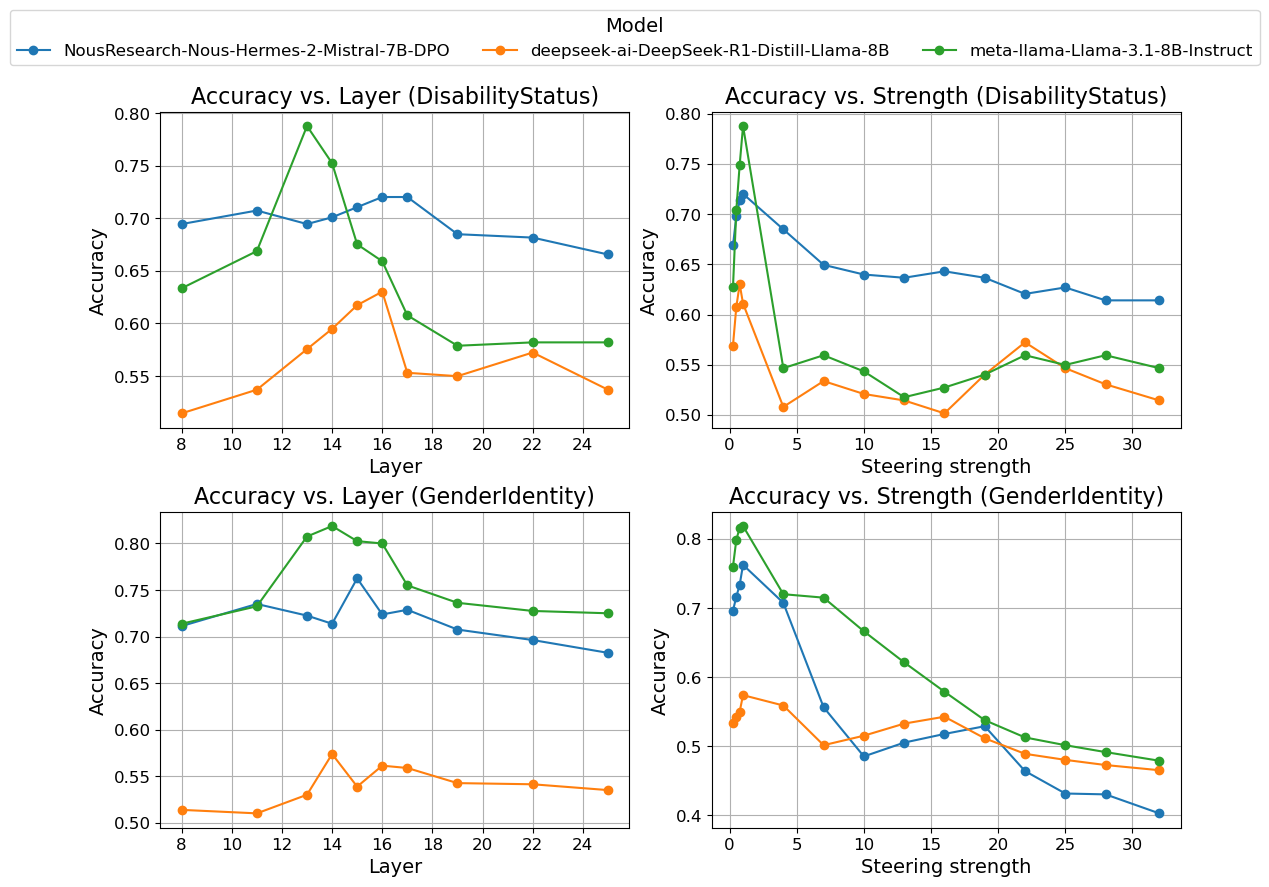

In [24]:
from matplotlib.ticker import MaxNLocator

def plot_2x2_single_strategy(
    model_names,
    root_dir,
    seed=1,
    feature="residual",
    benchmarks=("Religion", "Nationality"),
    strategy="iBAS_wrong_only",
    reduce_by="max",
    save_path=None
):
    if len(benchmarks) != 2:
        raise ValueError("Please pass exactly two benchmarks for a 2×2 grid.")

    # Collect data for both benchmarks
    b0_layer, b0_strength = _collect_series_for_benchmark(
        model_names, root_dir, seed, feature, benchmarks[0], strategy, reduce_by
    )
    b1_layer, b1_strength = _collect_series_for_benchmark(
        model_names, root_dir, seed, feature, benchmarks[1], strategy, reduce_by
    )

    fig, axes = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=True)

    # --- Top-left: Benchmark[0] Acc vs Layer ---
    ax = axes[0, 0]
    for model, d in b0_layer.items():
        ax.plot(d["layer"], d["accuracy"], marker="o", label=model)
    ax.set_xlabel("Layer", fontsize=14)
    ax.set_ylabel("Accuracy", fontsize=14)
    ax.set_title(f"Accuracy vs. Layer ({benchmarks[0]})", fontsize=16)
    ax.tick_params(axis="both", labelsize=12)
    ax.grid(True)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Force integer x-axis

    # --- Top-right: Benchmark[0] Acc vs Strength ---
    ax = axes[0, 1]
    for model, d in b0_strength.items():
        ax.plot(d["strength"], d["accuracy"], marker="o", label=model)
    ax.set_xlabel("Steering strength", fontsize=14)
    ax.set_ylabel("Accuracy", fontsize=14)
    ax.set_title(f"Accuracy vs. Strength ({benchmarks[0]})", fontsize=16)
    ax.tick_params(axis="both", labelsize=12)
    ax.grid(True)

    # --- Bottom-left: Benchmark[1] Acc vs Layer ---
    ax = axes[1, 0]
    for model, d in b1_layer.items():
        ax.plot(d["layer"], d["accuracy"], marker="o", label=model)
    ax.set_xlabel("Layer", fontsize=14)
    ax.set_ylabel("Accuracy", fontsize=14)
    ax.set_title(f"Accuracy vs. Layer ({benchmarks[1]})", fontsize=16)
    ax.tick_params(axis="both", labelsize=12)
    ax.grid(True)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Force integer x-axis

    # --- Bottom-right: Benchmark[1] Acc vs Strength ---
    ax = axes[1, 1]
    for model, d in b1_strength.items():
        ax.plot(d["strength"], d["accuracy"], marker="o", label=model)
    ax.set_xlabel("Steering strength", fontsize=14)
    ax.set_ylabel("Accuracy", fontsize=14)
    ax.set_title(f"Accuracy vs. Strength ({benchmarks[1]})", fontsize=16)
    ax.tick_params(axis="both", labelsize=12)
    ax.grid(True)

    # --- ONE legend for all plots, outside ---
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.1),
        ncol=len(model_names),
        title="Model",
        fontsize=12,
        title_fontsize=14
    )

    if save_path:
        fig.savefig(save_path, dpi=220, bbox_inches="tight")
    else:
        plt.show()
plot_2x2_single_strategy(
    model_names=model_list,
    root_dir="output_scale_up",
    seed=32,
    feature="residual",
    benchmarks=("DisabilityStatus", "GenderIdentity"),
    strategy="iBAS_wrong_only",  # <-- only this method is plotted
    reduce_by="max",
    save_path=None
    # save_path="plots/hyper_parameter.pdf" 
)


# Figure 4 and Figure 5

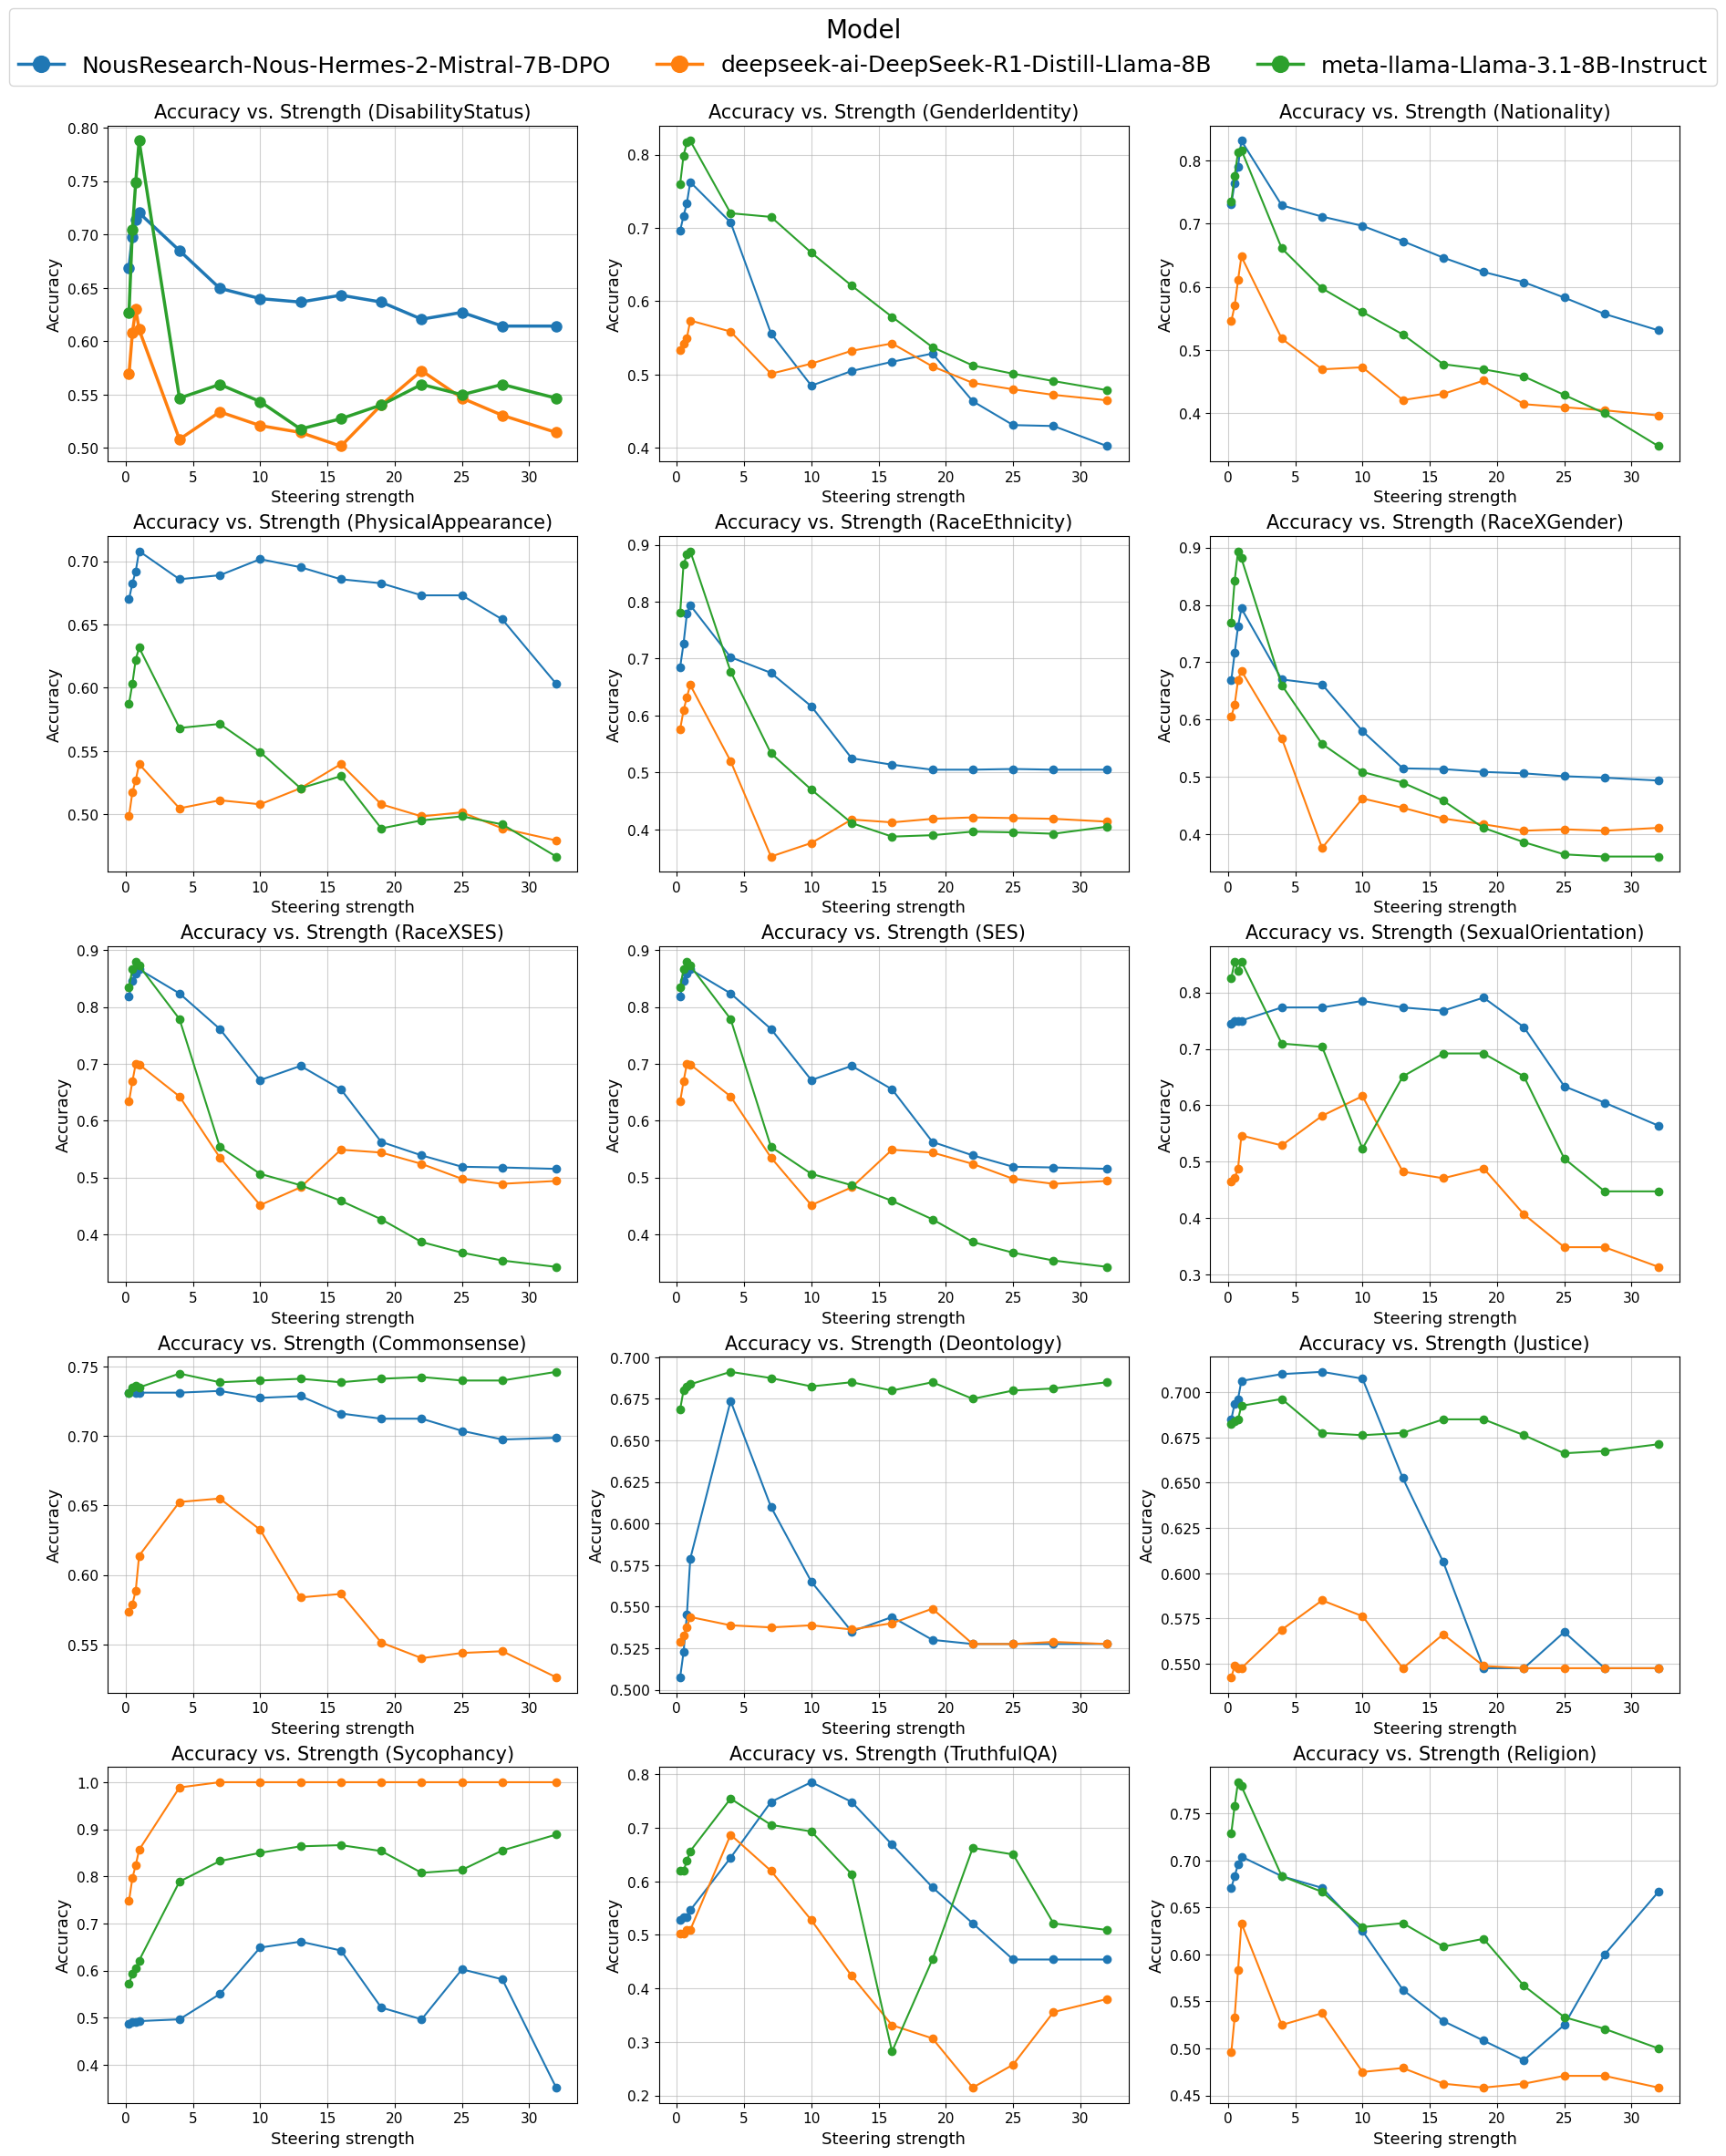

In [ ]:
from matplotlib.ticker import MaxNLocator

def plot_strength_only_single_strategy(
    model_names,
    root_dir,
    seed=1,
    feature="residual",
    benchmarks=("Religion", "Nationality"),
    strategy="iBAS_wrong_only",
    reduce_by="max",
    save_path=None,
    hyperparameter="steering_strength",   # "steering_strength" if Figure 4| "layer" if Figure 5
):
    """
    For each benchmark in `benchmarks`, make one subplot showing
    Accuracy vs. Steering Strength (default) or Accuracy vs. Layer (if hyperparameter="layer")
    for the given `strategy`, with one line per model in `model_names`.

    Uses:
      - _find_benchmark_csv(...)
      - _load_and_filter(...)
      - _collect_series_for_benchmark(...)

    reduce_by: "max" (default) or "mean" to aggregate duplicate strengths/layers.
    """
    if not benchmarks:
        raise ValueError("benchmarks must be a non-empty sequence")
    if hyperparameter not in ("steering_strength", "layer"):
        raise ValueError("hyperparameter must be 'steering_strength' or 'layer'")

    # Pre-collect per-benchmark data (both layer & strength series)
    bench_to_layer = {}
    bench_to_strength = {}
    for bench in benchmarks:
        per_model_layer, per_model_strength = _collect_series_for_benchmark(
            model_names, root_dir, seed, feature, bench, strategy, reduce_by
        )
        bench_to_layer[bench] = per_model_layer
        bench_to_strength[bench] = per_model_strength

    # Consistent colors per model across all subplots
    base_colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", None)
    if not base_colors:
        base_colors = [f"C{i}" for i in range(len(model_names))]
    color_map = {m: base_colors[i % len(base_colors)] for i, m in enumerate(model_names)}

    # Auto grid: up to 3 columns, as many rows as needed
    n_bench = len(benchmarks)
    ncols = min(3, n_bench)
    nrows = math.ceil(n_bench / ncols)

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(6.0 * ncols, 4.5 * nrows),
        constrained_layout=True
    )
    # Normalize axes to a 2D array for easy indexing
    if nrows == 1 and ncols == 1:
        axes = [[axes]]
    elif nrows == 1:
        axes = [axes]
    elif ncols == 1:
        axes = [[ax] for ax in axes]

    first_ax_with_data = None

    # Plot each benchmark in its own subplot
    for idx, bench in enumerate(benchmarks):
        r, c = divmod(idx, ncols)
        ax = axes[r][c]

        if hyperparameter == "steering_strength":
            per_model_series = bench_to_strength.get(bench, {})
            xcol = "strength"
            xlab = "Steering strength"
            title_tag = "Strength"
        else:  # hyperparameter == "layer"
            per_model_series = bench_to_layer.get(bench, {})
            xcol = "layer"
            xlab = "Layer"
            title_tag = "Layer"

        if not per_model_series:
            ax.set_title(f"Accuracy vs. {title_tag} ({bench})\n(no data)", fontsize=14)
            ax.axis("off")
            continue

        # Draw one line per model
        for model in model_names:
            d = per_model_series.get(model)
            if d is None or d.empty:
                continue
            ax.plot(
                d[xcol], d["accuracy"],
                marker="o", label=model, color=color_map[model]
            )

        ax.set_xlabel(xlab, fontsize=13)
        ax.set_ylabel("Accuracy", fontsize=13)
        ax.set_title(f"Accuracy vs. {title_tag} ({bench})", fontsize=15)
        ax.tick_params(axis="both", labelsize=11)
        ax.grid(True, alpha=0.6)

        # Force integer ticks only if x-axis is layer
        if hyperparameter == "layer":
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        if first_ax_with_data is None and ax.has_data():
            first_ax_with_data = ax

    # Turn off any extra (unused) axes if grid is larger than #benchmarks
    for k in range(len(benchmarks), nrows * ncols):
        r, c = divmod(k, ncols)
        axes[r][c].axis("off")

    # One shared legend (outside the grid)
    if first_ax_with_data is not None:
        handles, labels = first_ax_with_data.get_legend_handles_labels()
        if handles:
            plt.setp(handles, linewidth=2.5, markersize=8)  # affects legend appearance
            fig.legend(
                handles, labels,
                loc="upper center", bbox_to_anchor=(0.5, 1.05),
                ncol=min(len(model_names), 4),
                title="Model",
                fontsize=18,
                title_fontsize=20,
                markerscale=1.6
            )

    if save_path:
        fig.savefig(save_path, dpi=220, bbox_inches="tight")
    else:
        plt.show()


model_list = [
    "NousResearch-Nous-Hermes-2-Mistral-7B-DPO",
    "deepseek-ai-DeepSeek-R1-Distill-Llama-8B",
    "meta-llama-Llama-3.1-8B-Instruct",
]

plot_strength_only_single_strategy(
    model_names=model_list,
    root_dir="output_scale_up",
    seed=32,
    feature="residual",
    benchmarks=(
        "DisabilityStatus","GenderIdentity","Nationality","PhysicalAppearance",
        "RaceEthnicity","RaceXGender","RaceXSES","SES","SexualOrientation",
        "Commonsense","Deontology","Justice","Sycophancy","TruthfulQA","Religion"
    ),
    # benchmarks=(
    #    "Sycophancy"
    # ),
    strategy="iBAS_wrong_only",
    reduce_by="max",
    hyperparameter="steering_strength",   # "steering_strength" | "layer"
    save_path=None  
    # save_path= "plots/acc_strength.pdf"
    # save_path= "plots/acc_layer.pdf"
)


# Sample Size Sensitivity Analysis (Figure 6-8)

/tmp/ipykernel_1806200/472723294.py:168: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0.04, 0.02, 1, 0.92])


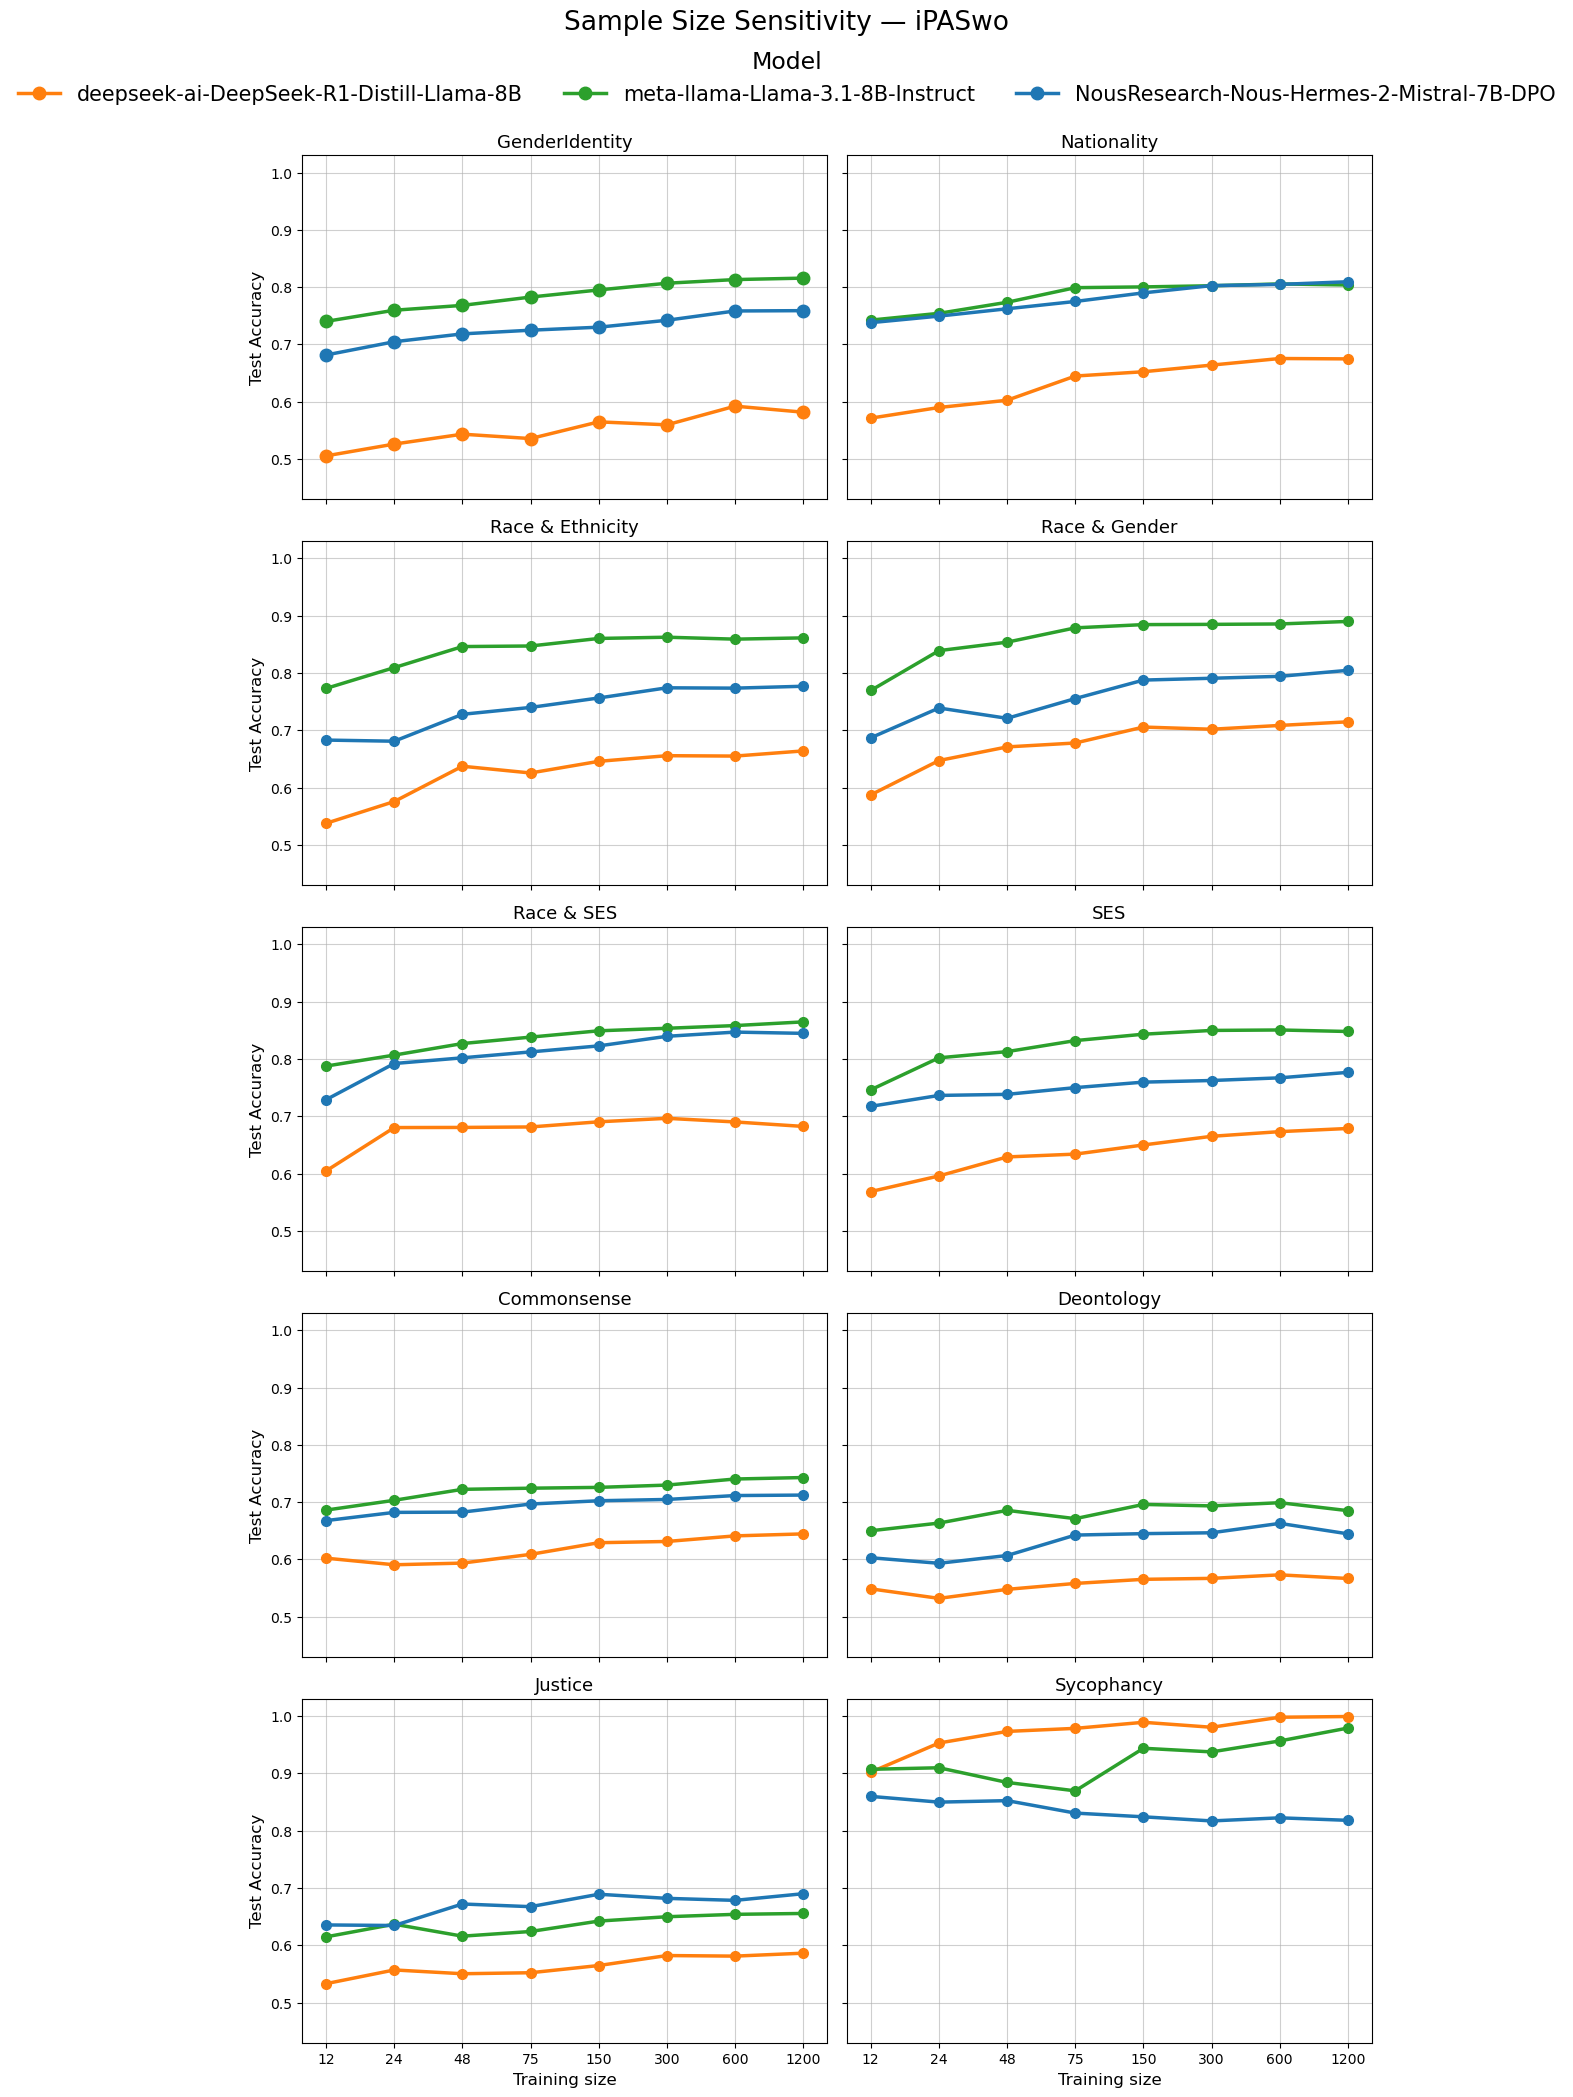

In [ ]:
# === Sample Size Sensitivity Analysis (5x2, renamed methods/benchmarks, top legend) ===
from collections import defaultdict

# -------- Parameters --------
ROOT = Path("output_sample_size_sensitivity")
METHOD = "iBAS_wrong_only"   # "BAS_full_mcq" if Figure 6 | "iBAS_all" if Figure 7 | "iBAS_wrong_only" if Figure 8

MODELS = [
    "deepseek-ai-DeepSeek-R1-Distill-Llama-8B",
    "meta-llama-Llama-3.1-8B-Instruct",
    "NousResearch-Nous-Hermes-2-Mistral-7B-DPO",
]

SEEDS = list(range(16, 31))
SIZES = [816, 832, 860, 900, 1000, 1200, 1600, 2400]
split_map = {816: 12, 832: 24, 860: 48, 900: 75, 1000: 150, 1200: 300, 1600: 600, 2400: 1200}
size_dirs = {s: f"max{s}" for s in SIZES}

BENCHMARKS = [
    "GenderIdentity",
    "Nationality",
    "RaceEthnicity",
    "RaceXGender",
    "RaceXSES",
    "SES",
    "ETHICS_Commonsense",
    "ETHICS_Deontology",
    "ETHICS_Justice",
    "Sycophancy",
]

# --- map method to short label for figure title ---
METHOD_LABELS = {
    "iBAS_wrong_only": "iPASwo",
    "BAS_full_mcq": "PASf",
    "iBAS_all": "iPASa",
}
method_label = METHOD_LABELS.get(METHOD, METHOD)

# --- color map---
_base_colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", ["C0","C1","C2"])
COLOR_MAP = {
    "NousResearch-Nous-Hermes-2-Mistral-7B-DPO": _base_colors[0],
    "deepseek-ai-DeepSeek-R1-Distill-Llama-8B": _base_colors[1],
    "meta-llama-Llama-3.1-8B-Instruct": _base_colors[2],
}

def clean_benchmark_name(name: str) -> str:
    if name.startswith("ETHICS_"):
        name = name.replace("ETHICS_", "")
    if name == "RaceXGender":
        return "Race & Gender"
    if name == "RaceXSES":
        return "Race & SES"
    if name == "RaceEthnicity":
        return "Race & Ethnicity"
    return name

def find_summary_csv(max_folder: Path) -> Path | None:
    p1 = max_folder / "results" / "tables" / "cross_benchmark_summary.csv"
    if p1.exists():
        return p1
    matches = list(max_folder.rglob("cross_benchmark_summary.csv"))
    if matches:
        matches.sort(key=lambda p: len(str(p)))
        return matches[0]
    return None

# -------- Aggregate Test-Acc across seeds --------
accs = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for model in MODELS:
    for seed in SEEDS:
        for s in SIZES:
            max_folder = ROOT / model / "residual" / f"seed_{seed}" / size_dirs[s]
            csv_path = find_summary_csv(max_folder)
            if not csv_path or not csv_path.exists():
                continue
            try:
                df = pd.read_csv(csv_path)
            except Exception:
                continue
            df.columns = [c.strip() for c in df.columns]
            if not {"Method","Benchmark","Test-Acc"}.issubset(df.columns):
                continue
            sub = df[df["Method"] == METHOD]
            if sub.empty:
                continue
            for _, r in sub.iterrows():
                try:
                    test_acc = float(r["Test-Acc"])
                except Exception:
                    continue
                accs[str(r["Benchmark"])][model][s].append(test_acc)

means = defaultdict(lambda: defaultdict(dict))
for bmk in BENCHMARKS:
    for model in MODELS:
        for s in SIZES:
            vals = accs[bmk][model][s]
            if vals:
                means[bmk][model][s] = float(np.mean(vals))

# -------- Plot: 5x2 layout --------
xpos = np.arange(len(SIZES))
xlabels = [split_map[s] for s in SIZES]

nrows, ncols = 5, 2
figsize = (6.0 * ncols, 4.5 * nrows)
fig, axes = plt.subplots(
    nrows, ncols,
    figsize=figsize, sharex=True, sharey=True,
    constrained_layout=True
)
fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, wspace=0.06, hspace=0.10)
axes = axes.ravel()

first_ax_with_data = None

for idx, bmk in enumerate(BENCHMARKS):
    ax = axes[idx]
    for model in MODELS:
        y = [means[bmk][model].get(s, np.nan) for s in SIZES]
        y = np.array(y, dtype=float)
        if np.isfinite(y).any():
            ax.plot(
                xpos, y, marker="o", label=model,
                color=COLOR_MAP[model], linewidth=2.5, markersize=7
            )
            if first_ax_with_data is None:
                first_ax_with_data = ax
    ax.set_title(clean_benchmark_name(bmk), fontsize=13)
    ax.grid(True, alpha=0.6)
    ax.set_ylim(0.43, 1.03)
    ax.tick_params(axis="both", labelsize=10)

    if idx // ncols == (nrows - 1):
        ax.set_xticks(xpos, xlabels)
        ax.set_xlabel("Training size", fontsize=12)
    else:
        ax.set_xticks(xpos, [""]*len(xpos))
        ax.set_xlabel("")
    if idx % ncols == 0:
        ax.set_ylabel("Test Accuracy", fontsize=12)
    else:
        ax.set_ylabel("")

for j in range(len(BENCHMARKS), nrows*ncols):
    axes[j].axis("off")

fig.suptitle(f"Sample Size Sensitivity — {method_label}", y=0.95, fontsize=19)

if first_ax_with_data is not None:
    handles, labels = first_ax_with_data.get_legend_handles_labels()
    if handles:
        plt.setp(handles, linewidth=2.5, markersize=9)
        fig.legend(
            handles, labels,
            loc="upper center", bbox_to_anchor=(0.5, 0.94),
            ncol=min(len(MODELS), 3),
            title="Model", fontsize=15, title_fontsize=17,
            markerscale=1.0, frameon=False
        )

fig.tight_layout(rect=[0.04, 0.02, 1, 0.92])
plt.show()

# fig.savefig(f"plots/sample_size_analysis_{method_label}.pdf", dpi=220, bbox_inches="tight")

